In [43]:
import numpy as np
import uproot
from matplotlib import pyplot as plt
import matplotlib as mpl
import h5py
from scipy import optimize
from src.process_h5_data import process_data
from src.graph import graph
from src.transmission import transmission
from utils import search_asc, search_desc, xsec_to_ts, tof_to_energy, energy_to_tof, chi_sq
from src.smear import smear

In [3]:
f = open("temp_data/Al.txt")
energy = []
crs = []
for line in f:
    energy.append(float(line[3:14]))
    crs.append(float(line[16:27]))
energy = np.array(energy)
crs = np.array(crs)

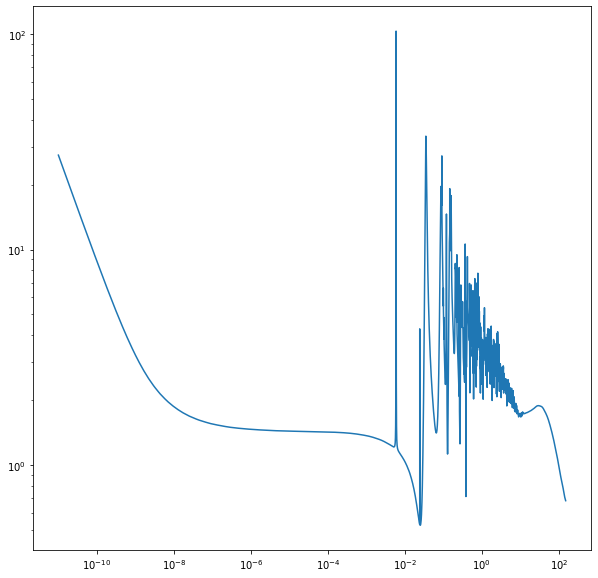

In [4]:
plt.figure(figsize=(10,10))
plt.plot(energy, crs)
plt.xscale('log')
plt.yscale('log')

In [6]:
rf = uproot.open("data/RF.root")
rfnp = rf['histfluka;1'].to_numpy()

In [16]:
rfnp[1][680]

6309.57344480193

In [17]:
np.average((rfnp[2][1:] + rfnp[2][:-1])/ 2, axis = 0, weights = rfnp[0][680])

29.297581812871297

In [18]:
np.sqrt(np.cov((rfnp[2][1:] + rfnp[2][:-1])/ 2, aweights= rfnp[0][680]))

36.625787157079486

In [46]:
ts = xsec_to_ts(crs * 1e-28, 2710, 0.05, 4.48e-26)

(5000.0, 7000.0)

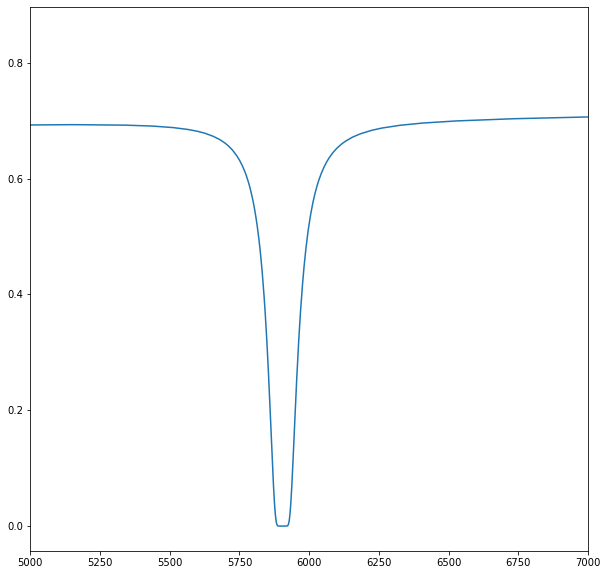

In [47]:
plt.figure(figsize=(10,10))
plt.plot(energy, ts)
plt.xlim(5000,7000)

In [25]:
AlIn = h5py.File("temp_data/Al5_fimg.hdf5", "r")
AlOut = h5py.File("temp_data/empty_fimg.hdf5", "r")

In [26]:
amp_AlIn = AlIn['amp'][:]
en_AlIn = AlIn['energy'][:]
tof_AlIn = AlIn['tof'][:]
norm_AlIn = AlIn['norm'][0]
amp_AlOut = AlOut['amp'][:]
en_AlOut = AlOut['energy'][:]
tof_AlOut = AlOut['tof'][:]
norm_AlOut = AlOut['norm'][0]

In [31]:
en_AlIn = tof_to_energy(tof_AlIn / 1e9, 183.04, 939.56542, 299792458) * 1e6
en_AlOut = tof_to_energy(tof_AlOut / 1e9, 183.04, 939.56542, 299792458) * 1e6

In [32]:
en_AlIn_select = en_AlIn[(en_AlIn > 5000) & (en_AlIn < 7000)]
en_AlOut_select = en_AlOut[(en_AlOut > 5000) & (en_AlOut < 7000)]

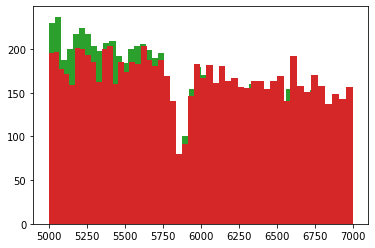

In [33]:
hist_AlIn, bins_AlIn, _, _ = graph(en_AlIn_select, 50)
hist_AlOut, bins_AlOut, _, _ = graph(en_AlOut_select, 50)

In [34]:
x_en = (bins_AlIn[1:] + bins_AlIn[:-1]) / 2

In [35]:
tr, tr_error = transmission(hist_AlIn / norm_AlIn, np.sqrt(hist_AlIn) / norm_AlIn, hist_AlOut / norm_AlOut, np.sqrt(hist_AlOut) / norm_AlOut)

In [49]:
y_ts = []
for x in x_en:
    index = search_asc(energy, x)
    y = ts[index]
    y_ts.append(y)

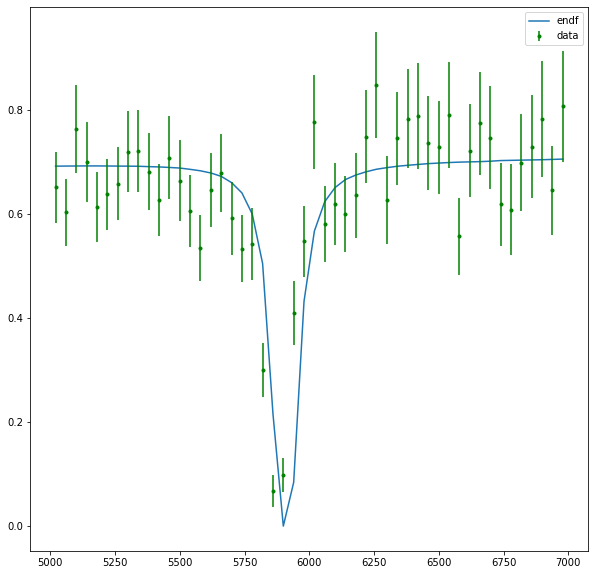

In [50]:
plt.figure(figsize=(10,10))
plt.plot(x_en, y_ts, label='endf')
plt.errorbar(x_en, tr, yerr=tr_error, label = 'data', fmt="g.")
plt.legend()

In [44]:
energy_smear, crs_smear = smear(energy, crs, 29/100, 37/100,5000, 7000, 100, 183.04)

In [53]:
ts_smear = xsec_to_ts(crs_smear * 1e-28, 2710, 0.05, 4.48e-26)

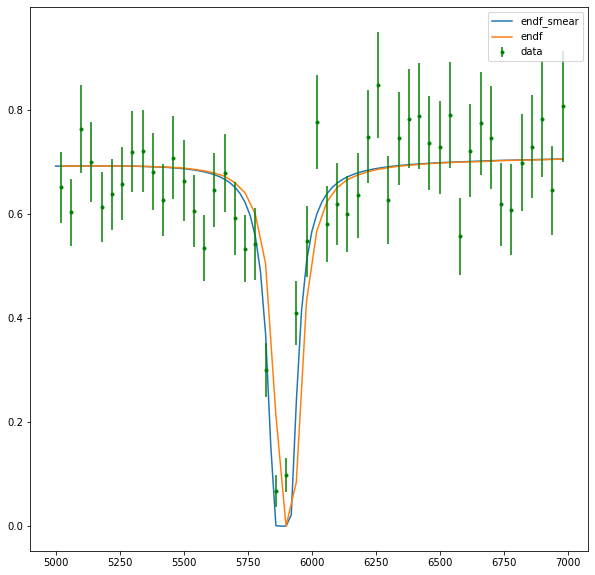

In [55]:
plt.figure(figsize=(10,10))
plt.plot(energy_smear, ts_smear,label='endf_smear')
plt.plot(x_en, y_ts, label='endf')
plt.errorbar(x_en, tr, yerr=tr_error, label = 'data', fmt="g.")
plt.legend()

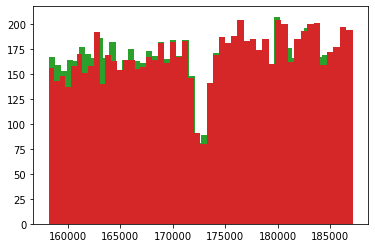

In [59]:
tof_AlIn_select = tof_AlIn[(en_AlIn > 5000) & (en_AlIn < 7000)]
tof_AlOut_select = tof_AlOut[(en_AlOut > 5000) & (en_AlOut < 7000)]
hist_AlIn, bins_AlIn, _, _ = graph(tof_AlIn_select, 50)
hist_AlOut, bins_AlOut, _, _ = graph(tof_AlOut_select, 50)
x_tof = (bins_AlIn[1:] + bins_AlIn[:-1]) / 2
error_AlIn =  np.sqrt(hist_AlIn)
error_AlIn[error_AlIn == 0] = 0.7
tr, tr_error = transmission(hist_AlIn / norm_AlIn, error_AlIn / norm_AlIn, hist_AlOut / norm_AlOut, np.sqrt(hist_AlOut) / norm_AlOut)

In [60]:
def y_fit(energy, L, t):
    energy_smear, crs_smear = smear(energy, crs, 29/100, 37/100, 5000, 7000, 100, L)
    ts = xsec_to_ts(np.array(crs_smear) * 1e-28, 2710, t, 4.48e-26)[::-1]
    tof = energy_to_tof(energy_smear / 1e6, L, 939.56542, 299792458)[::-1] * 1e9
    y_ts = []
    for x in x_tof:
        y_ts.append(np.interp(x, tof, ts))
    y_ts = np.array(y_ts)
    return y_ts

In [61]:
optimize.curve_fit(y_fit, energy, tr, sigma=tr_error, p0=[183, 0.05], absolute_sigma=True)

(array([1.83260055e+02, 5.23855027e-02]),
 array([[ 4.00049782e-03, -2.81775754e-06],
        [-2.81775754e-06,  4.46760512e-06]]))